Question 1: we may use two sample, two tailed z test, since sigma^2 is known

In [32]:
# generate normal distribution
#z_critical=(muA-muB)/sqrt(sigmaA^2/n+sigmaB^2/m)
delta<-1
ss<-1   #sigmaA^2=sigmaB^2
z_critical <- qnorm(p = 0.8)+1.96
n <- ceiling(2*ss/(delta/z_critical)^2)
cat("n value for current power(0.8) is: ", n)

n value for current power(0.8) is:  16

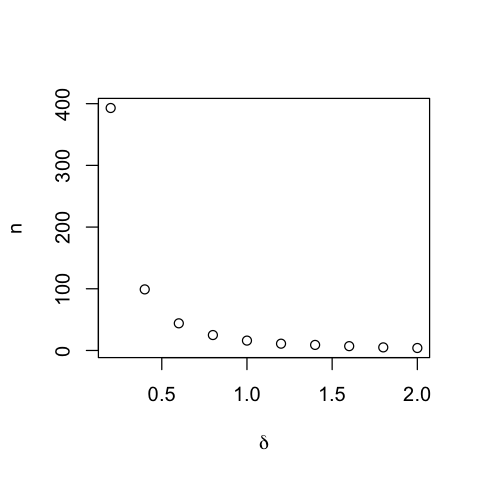

In [31]:
delta <- seq(0.2, 2, by=0.2)
ss<-1   #sigmaA^2=sigmaB^2
z_critical <- qnorm(p = 0.8)+1.96
n <- ceiling(2*ss/(delta/z_critical)^2)
options(repr.plot.width=4, repr.plot.height=4)
plot(delta, n, xlab=expression(delta), ylab="n")

In conclusion: when delta(muA-muB) increase, n decrease and distribute with square root

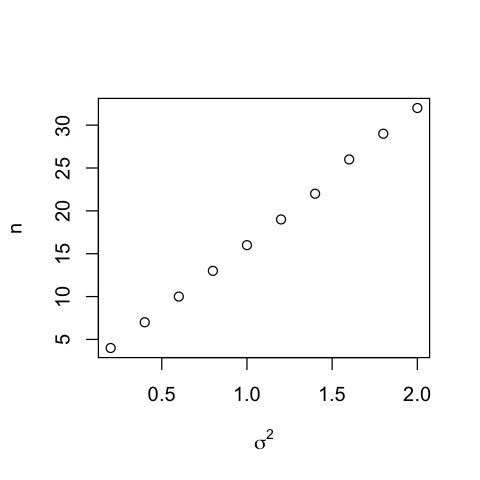

In [30]:
delta <- 1 
ss<- seq(0.2, 2, by=0.2)   #sigmaA^2=sigmaB^2
z_critical <- qnorm(p = 0.8)+1.96
n <- ceiling(2*ss/(delta/z_critical)^2)
options(repr.plot.width=4, repr.plot.height=4)
plot(ss, n, xlab=expression(sigma^2), ylab="n")

In conclusion: when sigma^2 increase, n decrease linearly

Noticed that the sample size n may be below 30, we therefore also need to consider t test

In [62]:
library(pwr)
delta <- 1 
ss<- sqrt((1+1)/2)  #sigmaA^2=sigmaB^2
pwr.t.test(d=(delta)/ss,power=.8,sig.level=.05,type="two.sample",alternative="two.sided")


     Two-sample t test power calculation 

              n = 16.71
              d = 1
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


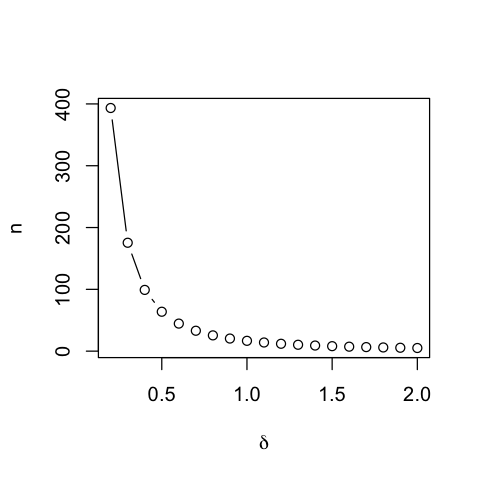

In [72]:
ptab<-cbind(NULL, NULL)       # initalize ptab
ss<- sqrt((1+1)/2)  #sigmaA^2=sigmaB^2
delta=c(.2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1, 1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0)
 for (i in delta){
   pwrt<-pwr.t.test(d=i/ss,power=.8,sig.level=.05,type="two.sample",alternative="two.sided")
   ptab<-rbind(ptab, cbind(pwrt$d, pwrt$n))
 }

plot(delta,ptab[,2],type="b",xlab=expression(delta),ylab="n")

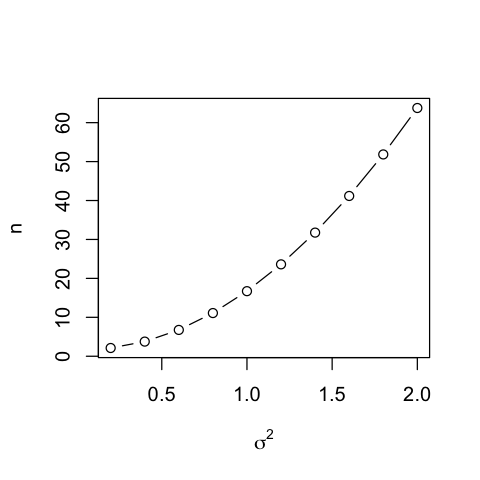

In [73]:
ptab<-cbind(NULL, NULL)       # initalize ptab
delta<-1
ss<- seq(0.2, 2, by=0.2)   #sigmaA^2=sigmaB^2
 for (i in ss){
   pwrt<-pwr.t.test(d=delta/i,power=.8,sig.level=.05,type="two.sample",alternative="two.sided")
   ptab<-rbind(ptab, cbind(pwrt$d, pwrt$n))
 }

plot(ss,ptab[,2],type="b",xlab=expression(sigma^2),ylab="n")

For t test, we need sample size n=m=17, and n decrease with increaing delta, n increase with increaing sigma^2

Question2: A new casino game involves rolling 3 dice. The winnings are directly proportional to the total number of sixes rolled. Suppose a gambler plays the game 101 times, with the following observed counts:
number of sixes      number of rolls
0                           48
1                           35 
2                           15
3                           3 

Experiment: If this dice is fair?
Null Hypothesis: Fair Dice P(n=k)=C3k*p^k*(1−p)^(3−k)
Alternative Hypothesis: Not Fair Coin

We can use chi-square test for goodness of fit
chi-square=sigma(all cells)(observed-expected)^2/expected

In [58]:
# chi-square test on code
options("scipen"=1, "digits"=4)
observed = c(48, 35, 15, 3)
expected.prob = c((5/6)^3, 3*5^2/(6^3), 3*5/(6^3), 1/(6^3))
expected = sum(observed) * expected.prob
chi2 = sum((observed - expected)^2/expected)
df = (length(observed) - 1)*(2-1)
p.val = 1 - pchisq(chi2, df)
cat("Chi-square:", chi2)


Chi-square: 24.68

In [55]:
cat("p-value:", p.val)

p-value: 0.00001804

For alpha=0.05, df=3, chi-square critical variable=7.815 < chi-square calculated here
We can say this is not a fair dice

Question3: feature engineering, transform existing features and generate new features

In [88]:
loan <- read.csv("loan.csv", stringsAsFactors = FALSE)

As we discussed before, earliest_cr_line and issue_d are two dates related features that may be most predictive, we can start feature enginnering with those two.

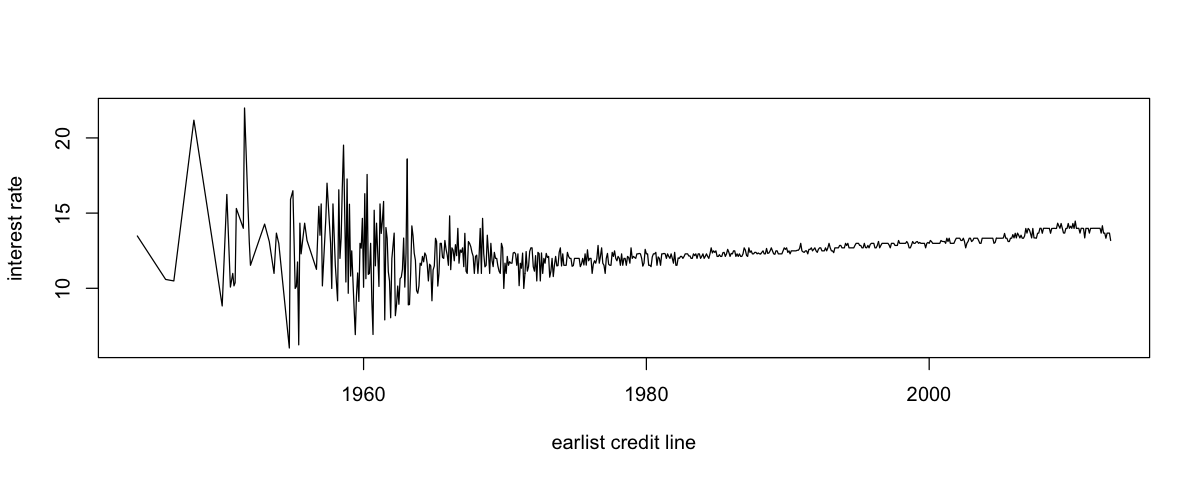

In [98]:
library(zoo)
loan$earliest_cr_line_1 <- as.Date(as.yearmon(loan$earliest_cr_line, "%b-%Y"))
loan$earliest_cr_line_year <- format(loan$earliest_cr_line_1, '%Y')
loan$earliest_cr_line_month <- format(loan$earliest_cr_line_1, '%m')
int.rate.by.ecl <- by(loan, loan$earliest_cr_line_1, function(x) {return(median(x$int_rate))})
plot(as.Date(names(int.rate.by.ecl)), int.rate.by.ecl, type = 'l',xlab="earlist credit line",ylab="interest rate")

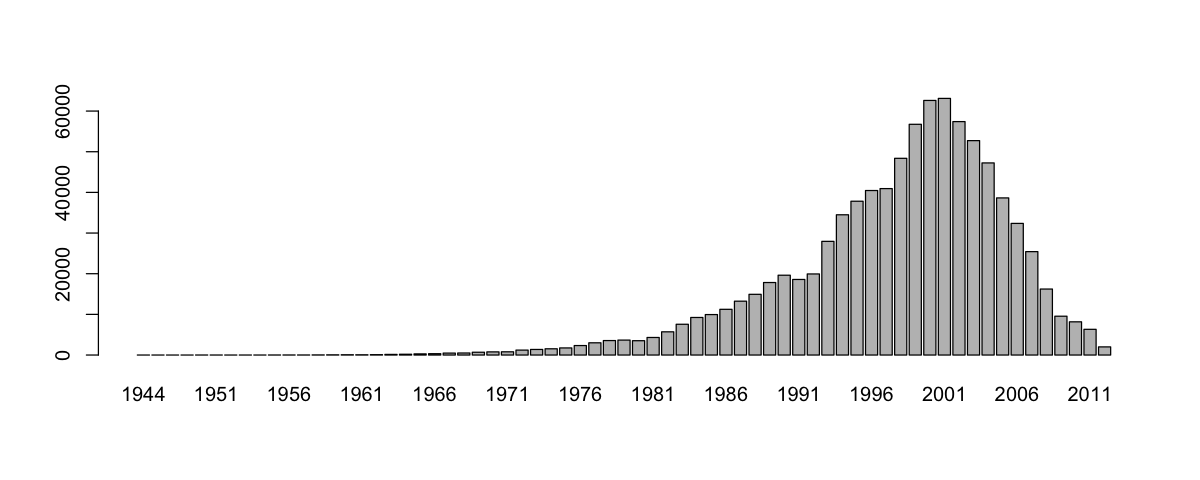

In [99]:
options(repr.plot.width=10, repr.plot.height=4)
barplot(table(loan$earliest_cr_line_year))

We can learn from the figure that the number of account with earliest credit line before year 1976 are too small, which may result in large error in the model fitting. 
Thus, we can trim the data before 1976, and do the chi-square test.

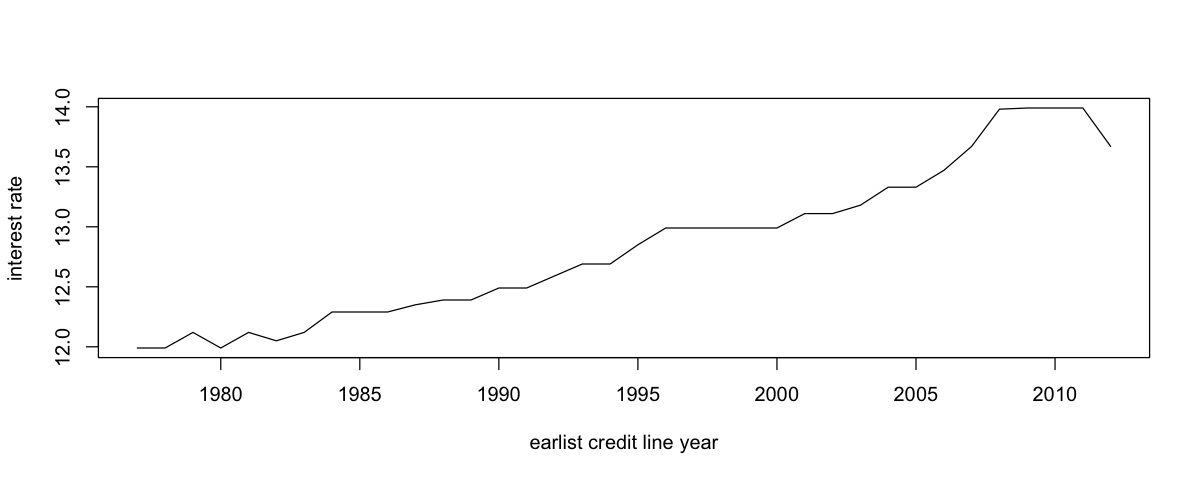

In [108]:
int.rate.by.ecl.y <- by(loan, loan$earliest_cr_line_year, function(x) {return(median(x$int_rate))})
int.rate.by.ecl.yf <- int.rate.by.ecl.y[which(names(int.rate.by.ecl.y)>1976)]
plot(names(int.rate.by.ecl.yf), int.rate.by.ecl.yf, type = 'l',xlab="earlist credit line year",ylab="interest rate")

In [114]:
# coorelation coefficient
 cor(as.numeric(names(int.rate.by.ecl.yf)),int.rate.by.ecl.yf, ) 

[1] 0.9762

When we filter the data with old years (before 1976 and new data set), we can largely increase the coorelation coefficient from 0.10 to 0.98, and we see a very clear trend with linearly increasing interest rate. 

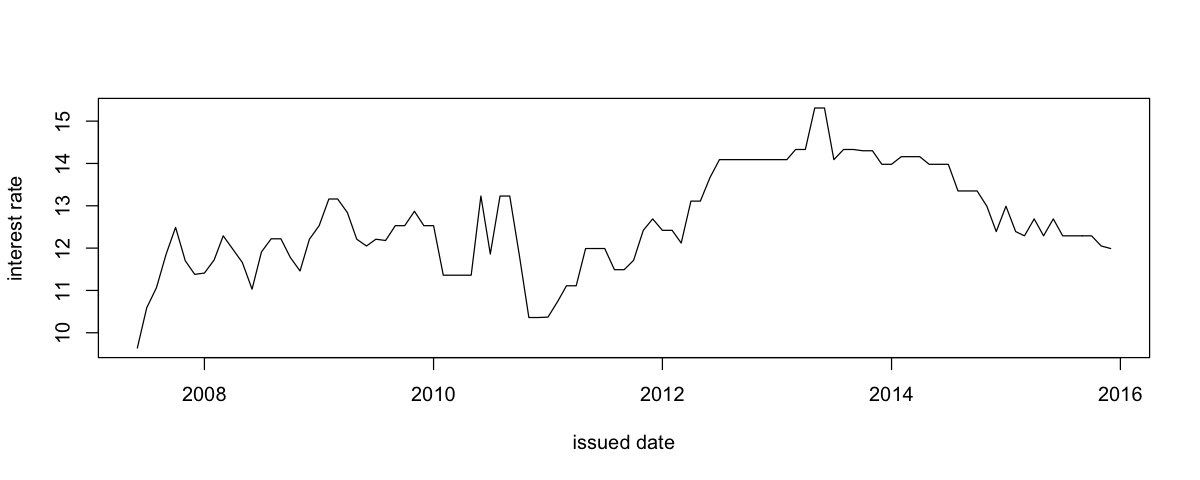

In [115]:
library(zoo)
loan$issue_d_1 <- as.Date(as.yearmon(loan$issue_d, "%b-%Y"))
loan$issue_year <- format(loan$issue_d_1, '%Y')
loan$issue_mon <- format(loan$issue_d_1, '%m')
int.rate.by.time <- by(loan, loan$issue_d_1, function(x) {return(median(x$int_rate))})
plot(as.Date(names(int.rate.by.time)), int.rate.by.time, type = 'l',xlab="issued date",ylab="interest rate")

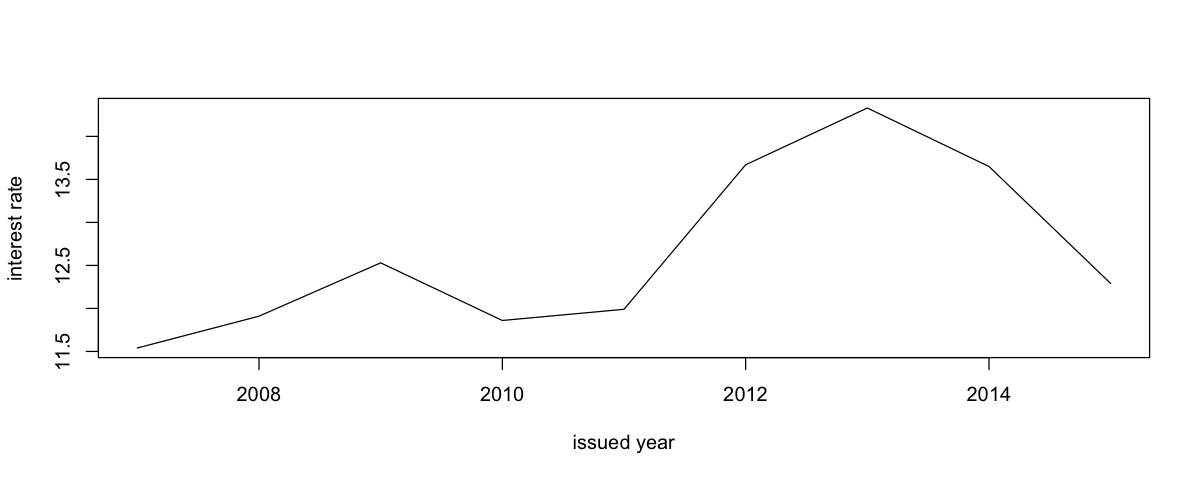

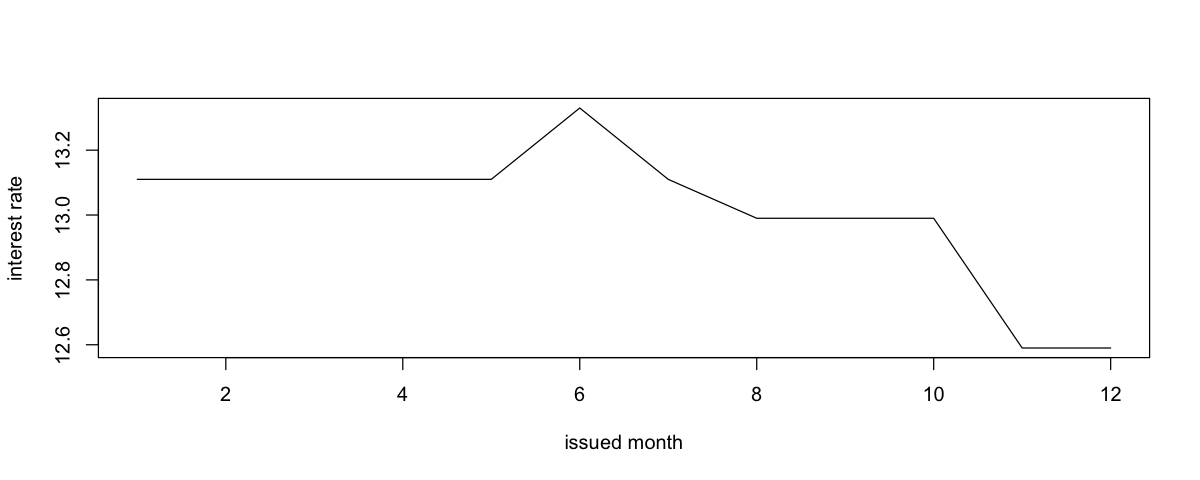

In [116]:
int.rate.by.year <- by(loan, loan$issue_year, function(x) {return(median(x$int_rate))})
plot(names(int.rate.by.year), int.rate.by.year, type = 'l',xlab="issued year",ylab="interest rate")
int.rate.by.month <- by(loan, loan$issue_mon, function(x) {return(median(x$int_rate))})
plot(names(int.rate.by.month), int.rate.by.month, type = 'l',xlab="issued month",ylab="interest rate")

Notice that interest rate have two peaks with issed year 2009 and 2013, we may guess there might be because of the market, or some breaking news happend in those two years. Also, November and December have very obvious lower interest rate than other time of the year. We may also table plot the number of lending account as a function of issued year. 

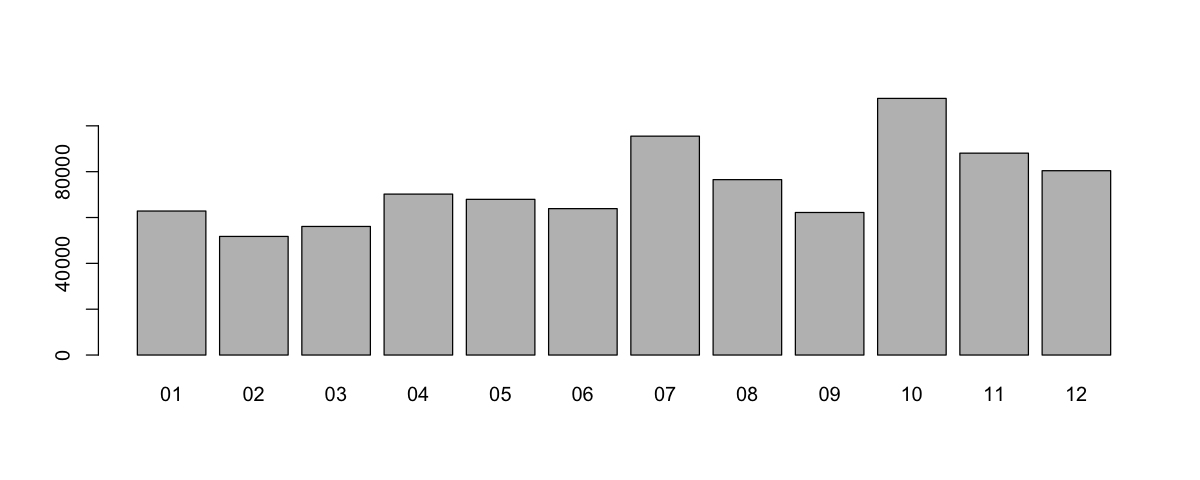

In [117]:
barplot(table(loan$issue_mon))

We can see that from October to December, the number of lending increase and interest rate decrease, may be because of holiday effect. 

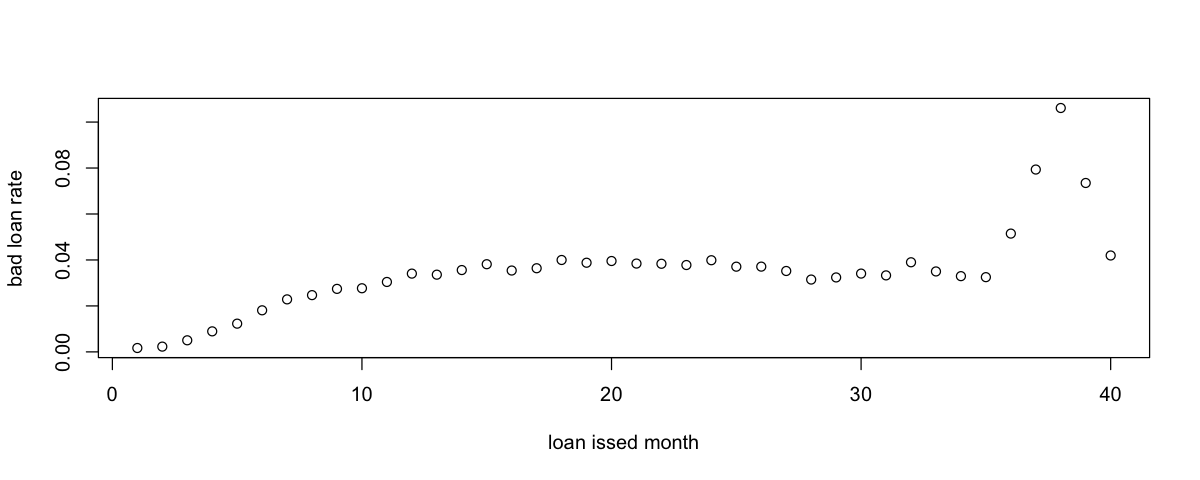

In [120]:
#Next, we looked at payment information and loan status
loan$next_pymnt_d_1 <- as.Date(as.yearmon(loan$next_pymnt_d, "%b-%Y"))
loan$last_pymnt_d_1 <- as.Date(as.yearmon(loan$last_pymnt_d, "%b-%Y"))
loan$days_since_issue <- as.numeric(with(loan, next_pymnt_d_1 - issue_d_1))  

loan$months_since_issue <- as.integer(with(loan, next_pymnt_d_1 - issue_d_1)/31)
loan$months_since_issue[which(loan$months_since_issue >= 40)] <- 40  #assign early issed accounts into one varaiable
bad.loan.by.month <- by(loan, loan$months_since_issue, function(x){
  return(dim(subset(x, loan_status %in% c('Charged Off', 'Default', 'Late (16-30 days)',
                                          'Late (31-120 days)')))[1]/dim(x)[1])})
plot(bad.loan.by.month,xlab="loan issed month",ylab="bad loan rate")

Among all the accounts, the next payment date to issed date is around 38 months may have the highest bad loan status. May be because of the label algorithm on Lending clubs, ie, some of the bad loan status account will not have updated next payment date. 
Here we can generate a new feature: loan issed month (next_pymnt_d - issue_d in month unit)

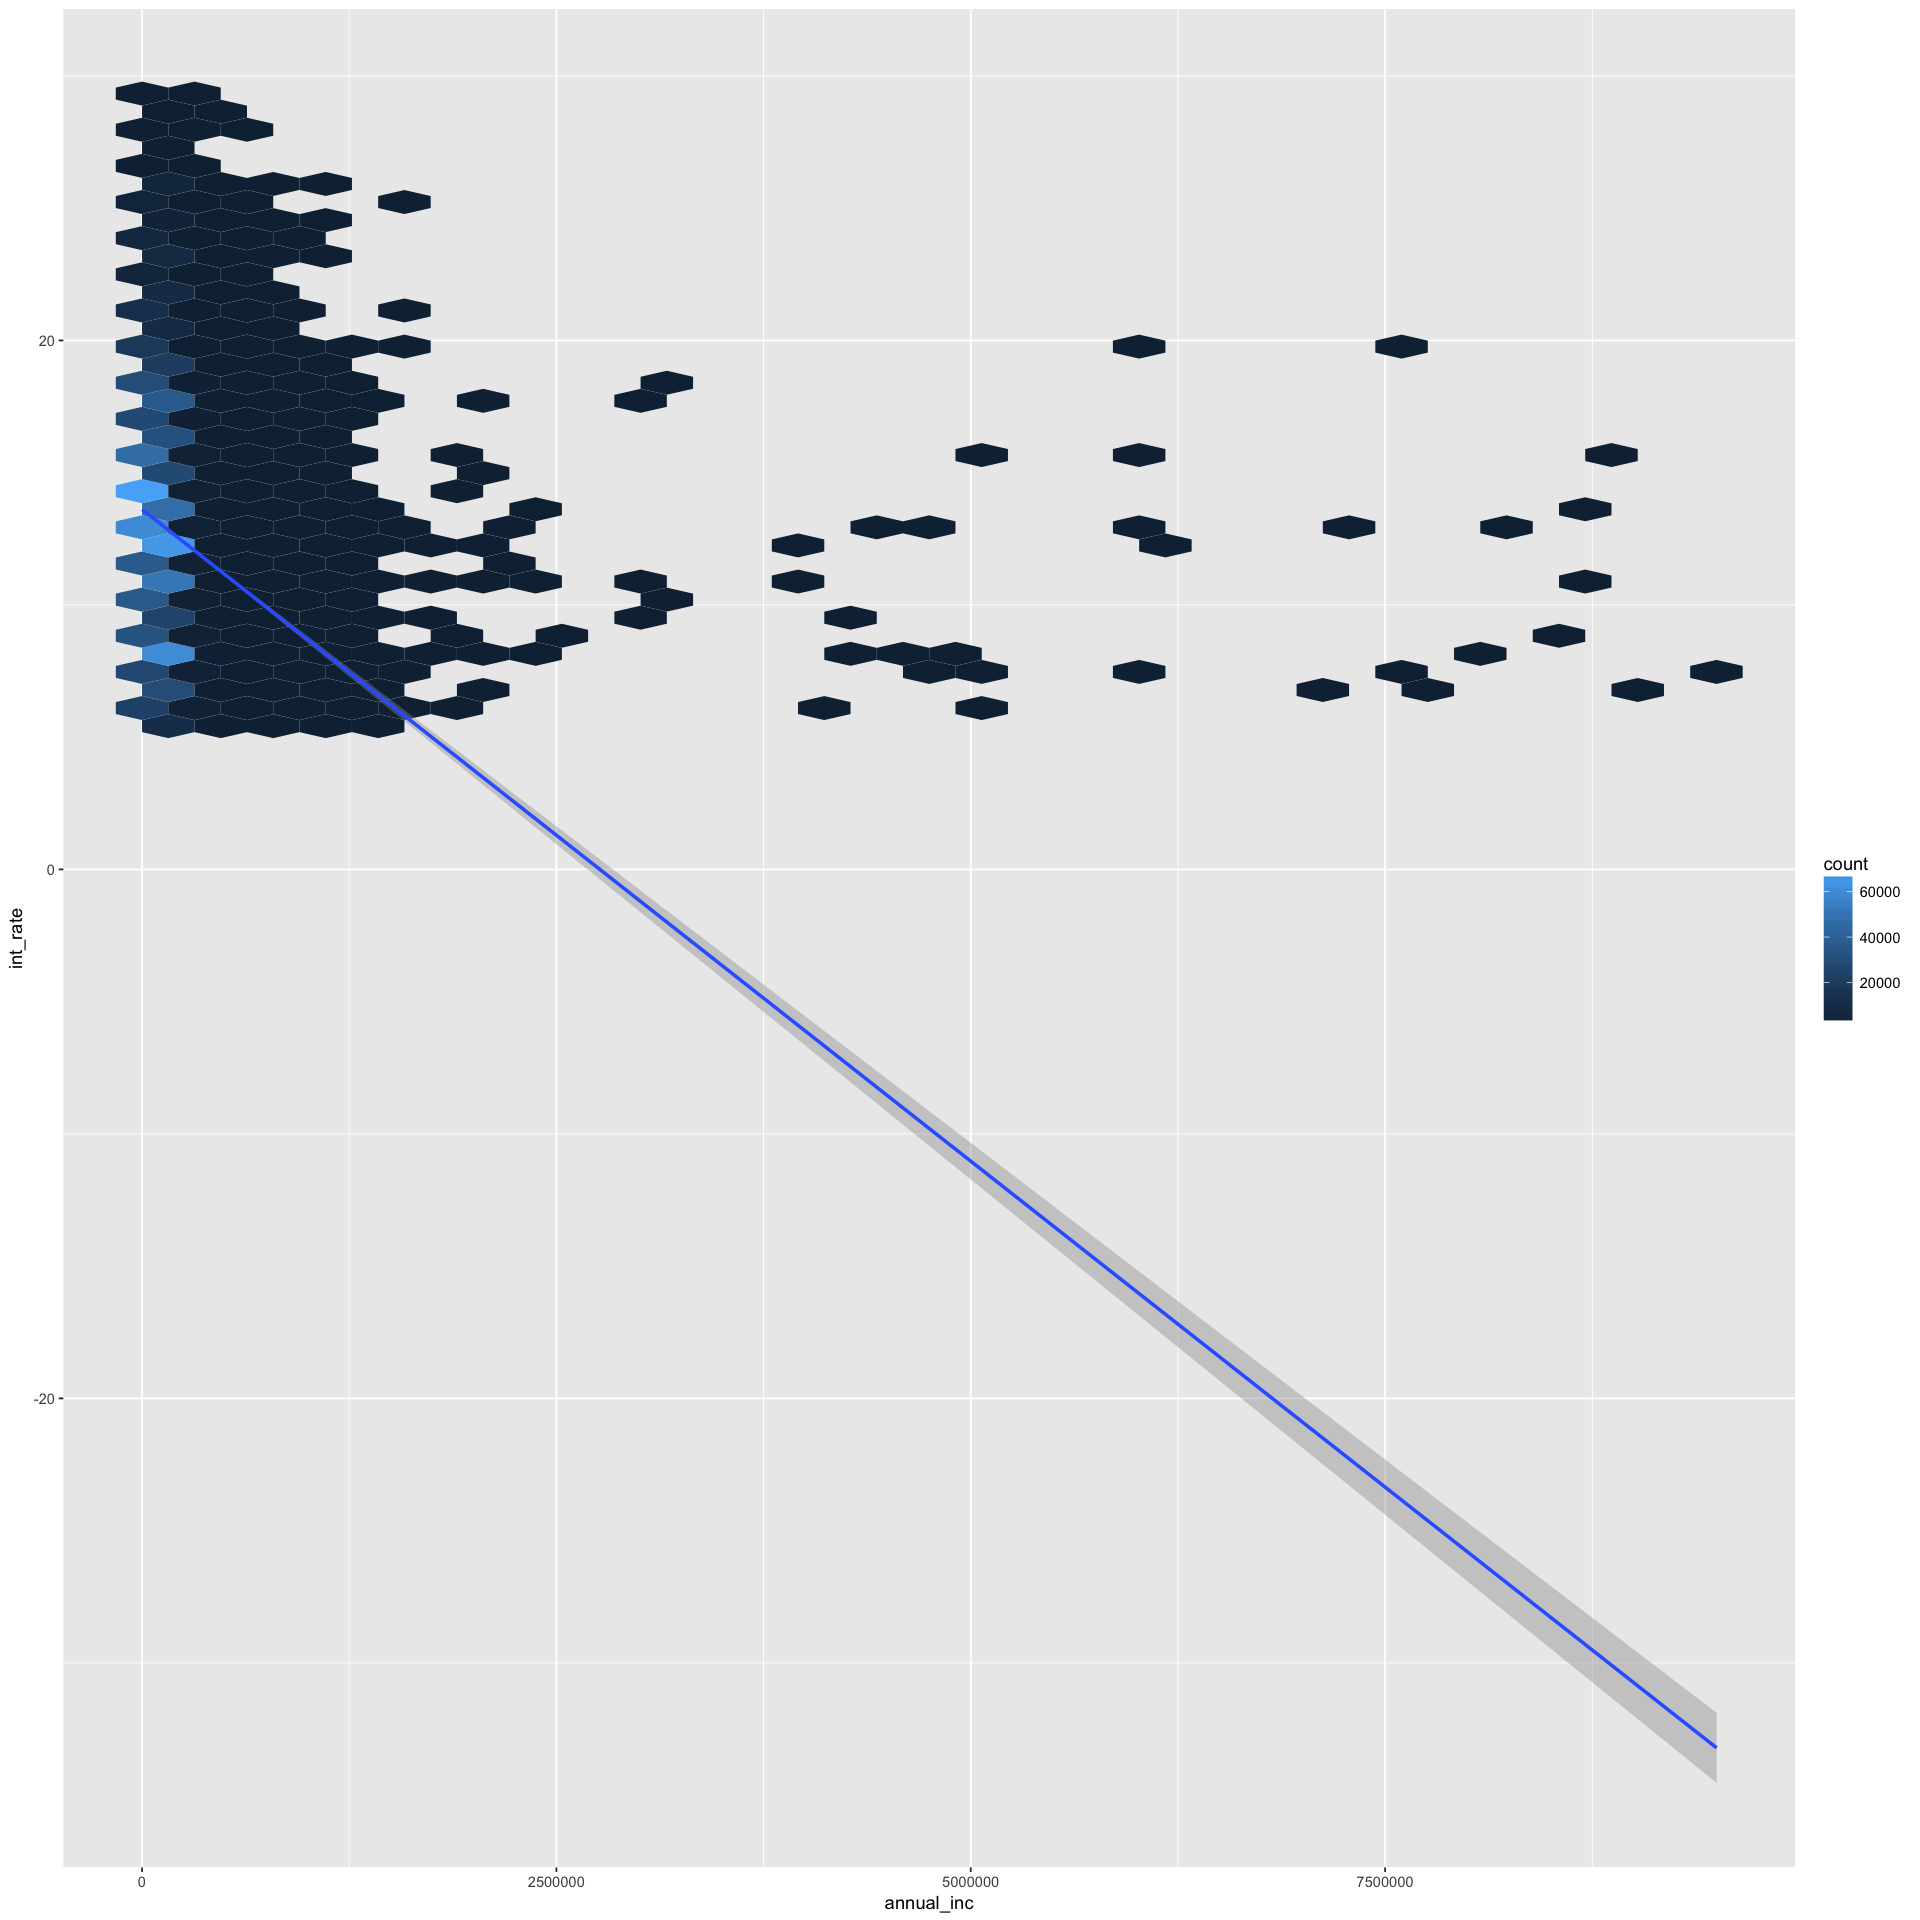

In [124]:
#replace loan annual_inc NA and 0 (doesn't make sense) value with mean value
loan$annual_inc[which(is.na(loan$annual_inc) | (loan$annual_inc == 0))] = mean(loan$annual_inc, na.rm=T)

# linear relationship, geom_hex(): Divides the plane into regular hexagons, 
#counts the number of cases in each hexagon, and then (by default) maps the number of cases to the hexagon fill
options(repr.plot.width=16, repr.plot.height=16)
ggplot(loan, aes(x = annual_inc, y=int_rate)) + geom_hex() + stat_smooth(method=lm)

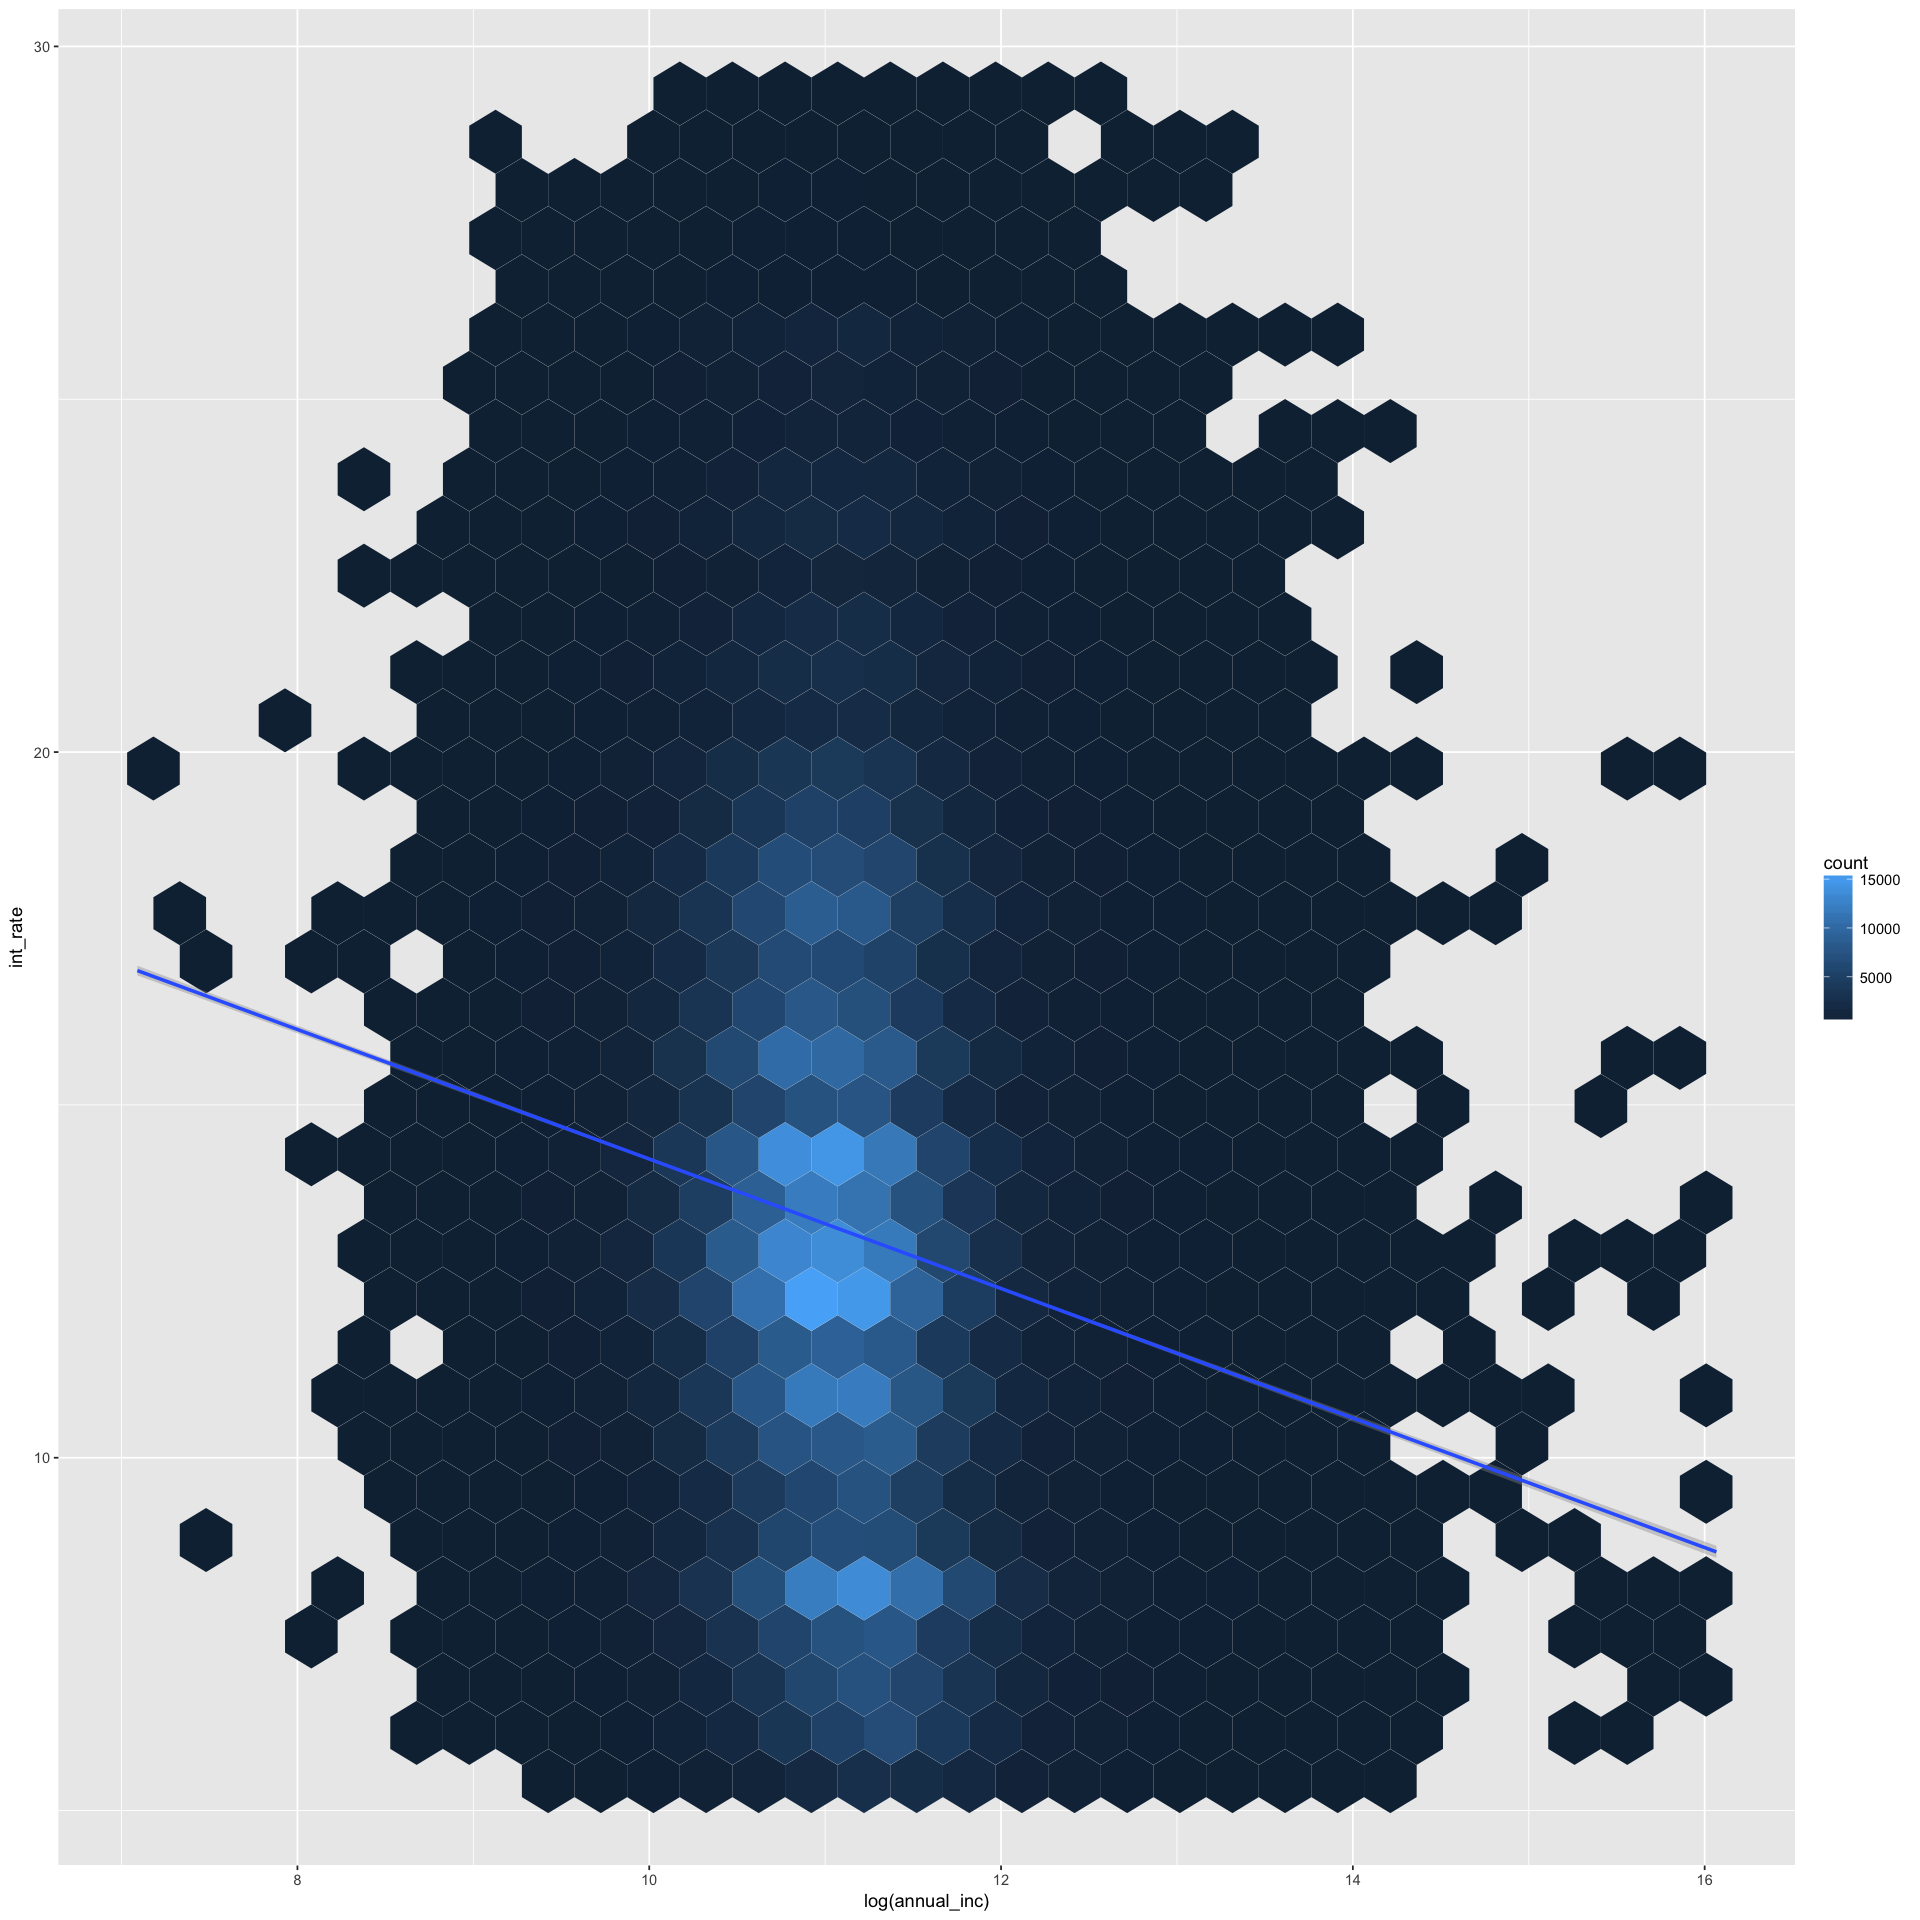

In [125]:
# linear relationship in log scale : possible feature engineering, log plot
options(repr.plot.width=16, repr.plot.height=16)
ggplot(loan, aes(x = log(annual_inc), y=int_rate)) + geom_hex() + stat_smooth(method=lm)

In [126]:
cor(loan$annual_inc, loan$int_rate)
# possible feature
cor(log(loan$annual_inc), loan$int_rate)

[1] -0.07278

[1] -0.1106

We learn from the coorelation coefficient that the log plot improve the feature annual income

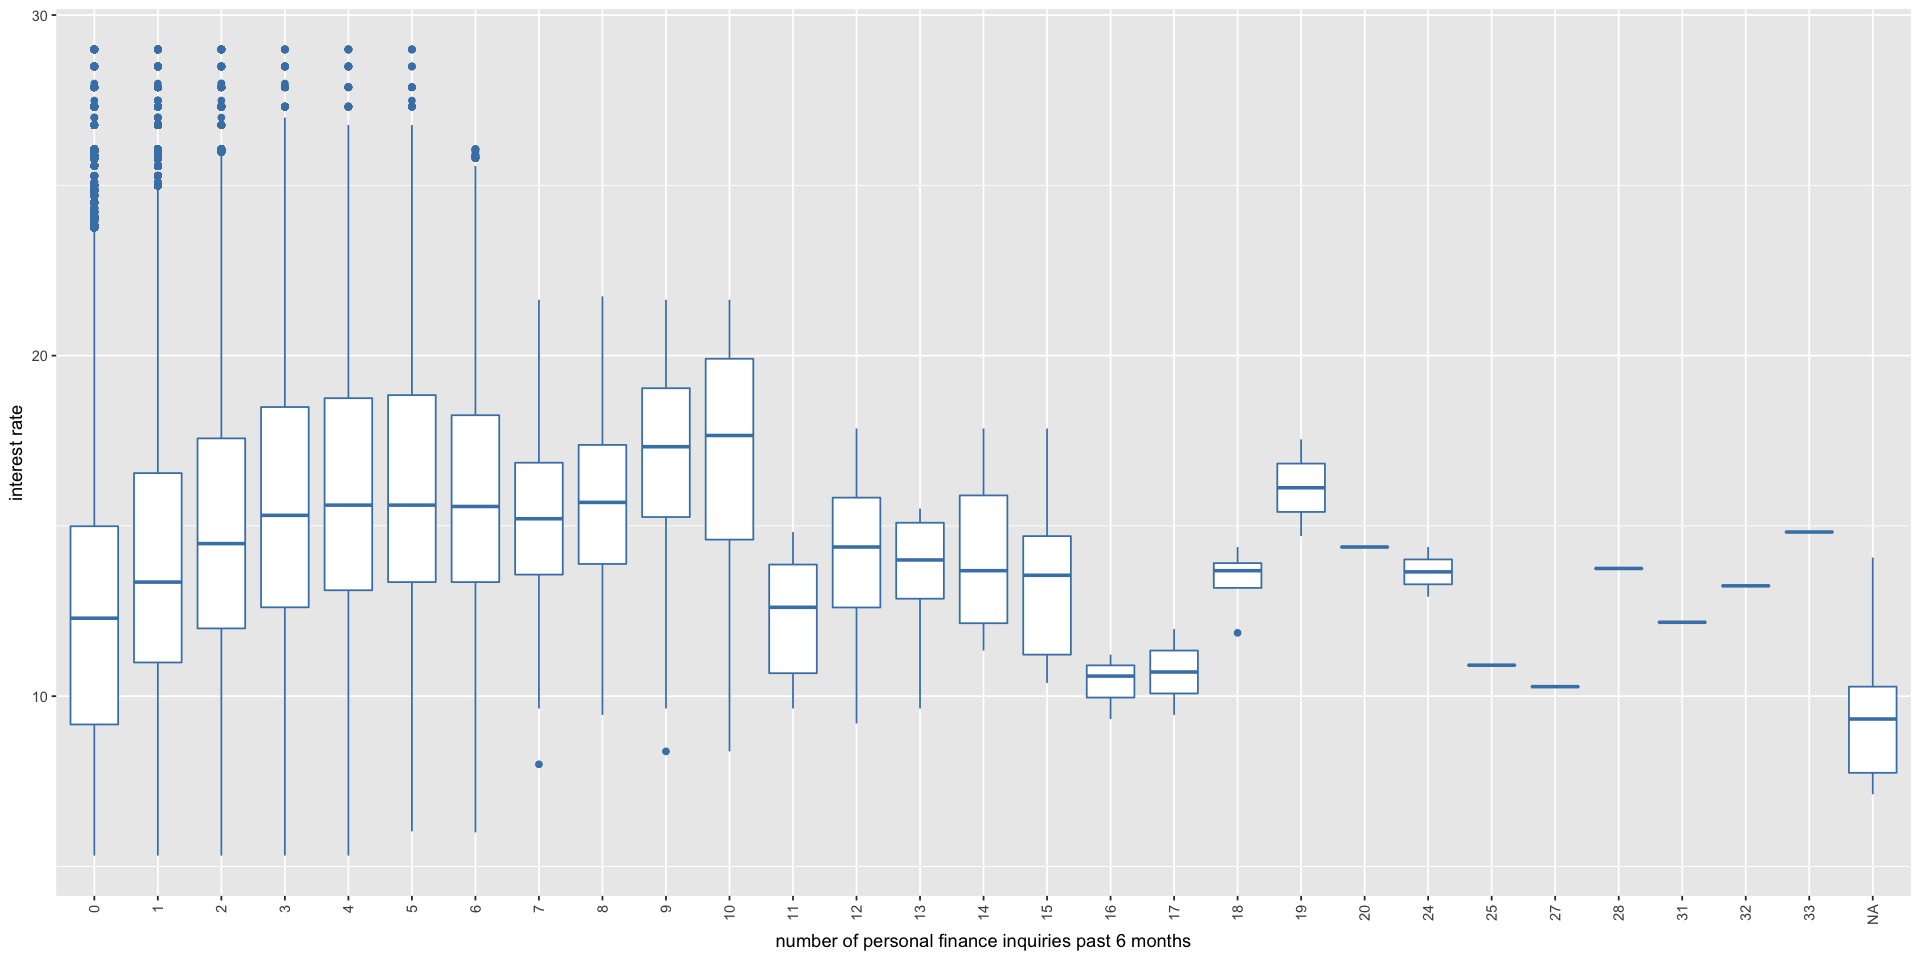

In [127]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(loan, aes(x=factor(inq_last_6mths), y=int_rate)) + 
geom_boxplot(color='steelblue') + labs(x='number of personal finance inquiries past 6 months', y="interest rate") + 
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=.5),
        legend.position = "none")

The data with inquiries over 10 times is only a few

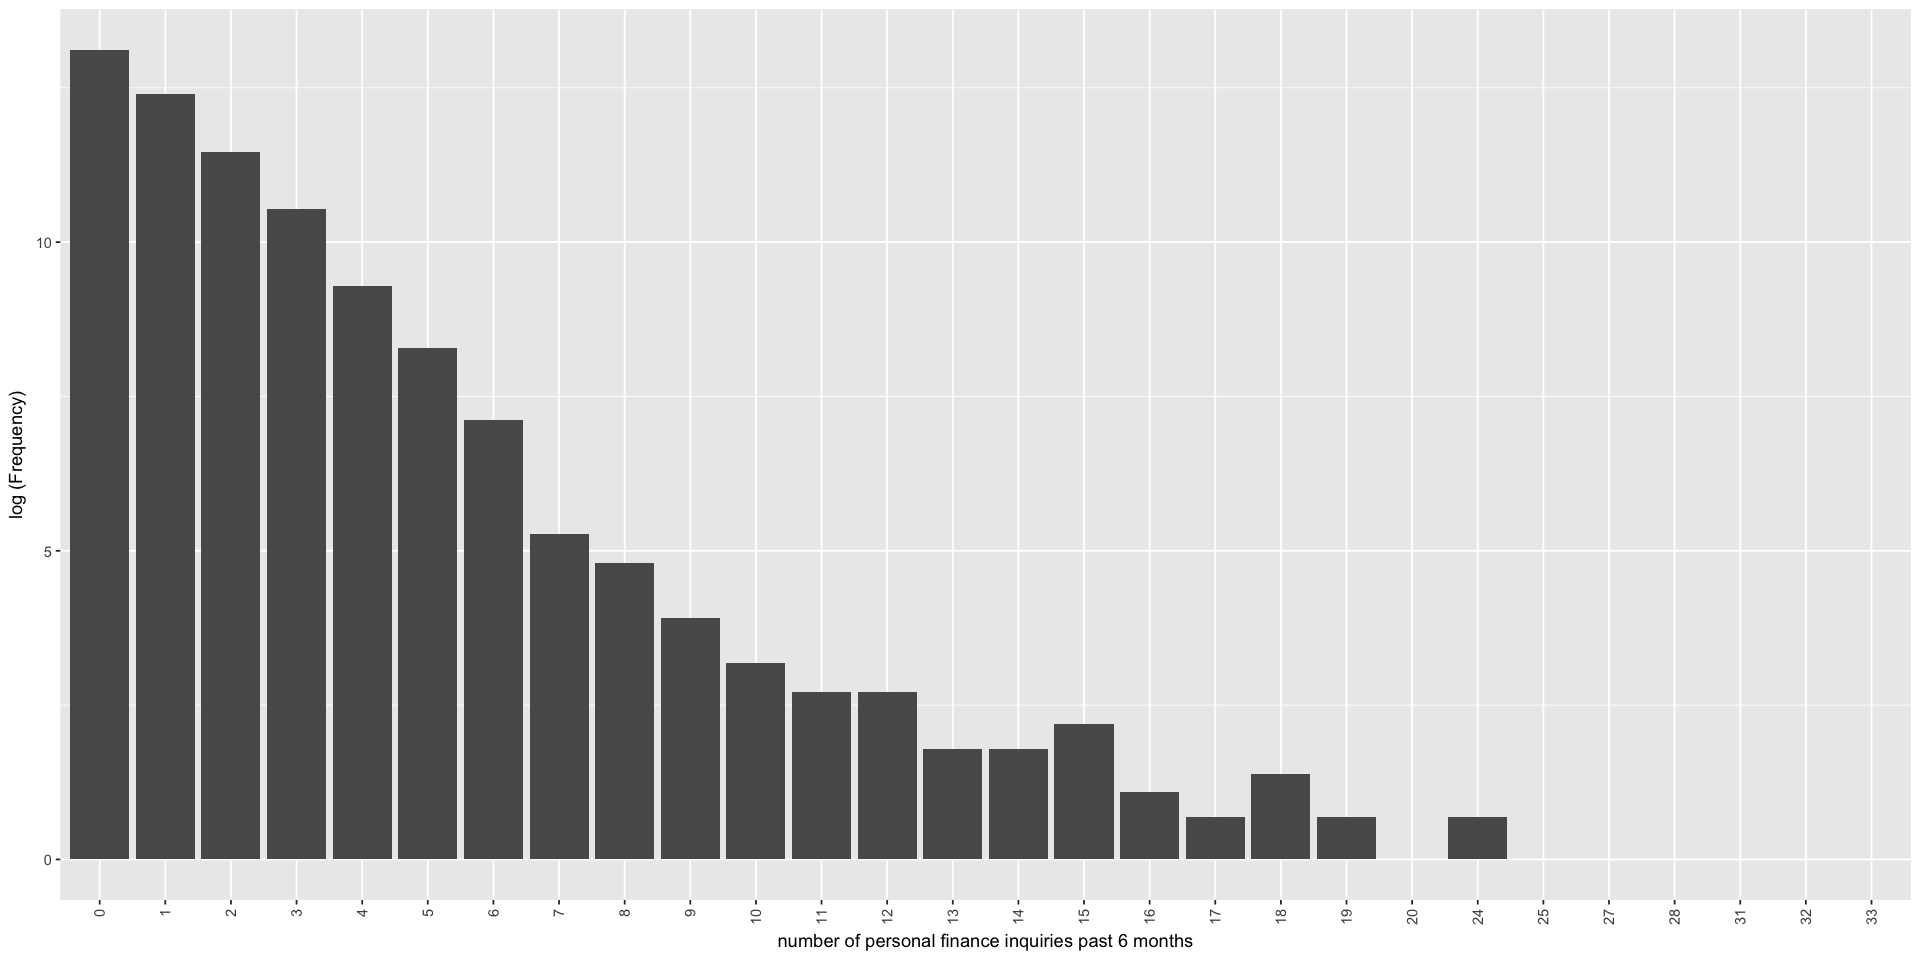

In [133]:
ggplot(as.data.frame(table(loan$inq_last_6mths)), aes(x=Var1, y=log(Freq))) + 
geom_bar(stat="identity") + labs(x='number of personal finance inquiries past 6 months', y="log (Frequency)")+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=.5),
        legend.position = "none")

In [152]:
sum(is.na(loan$inq_last_6mths))/dim(loan)[1]

[1] 0.00003268

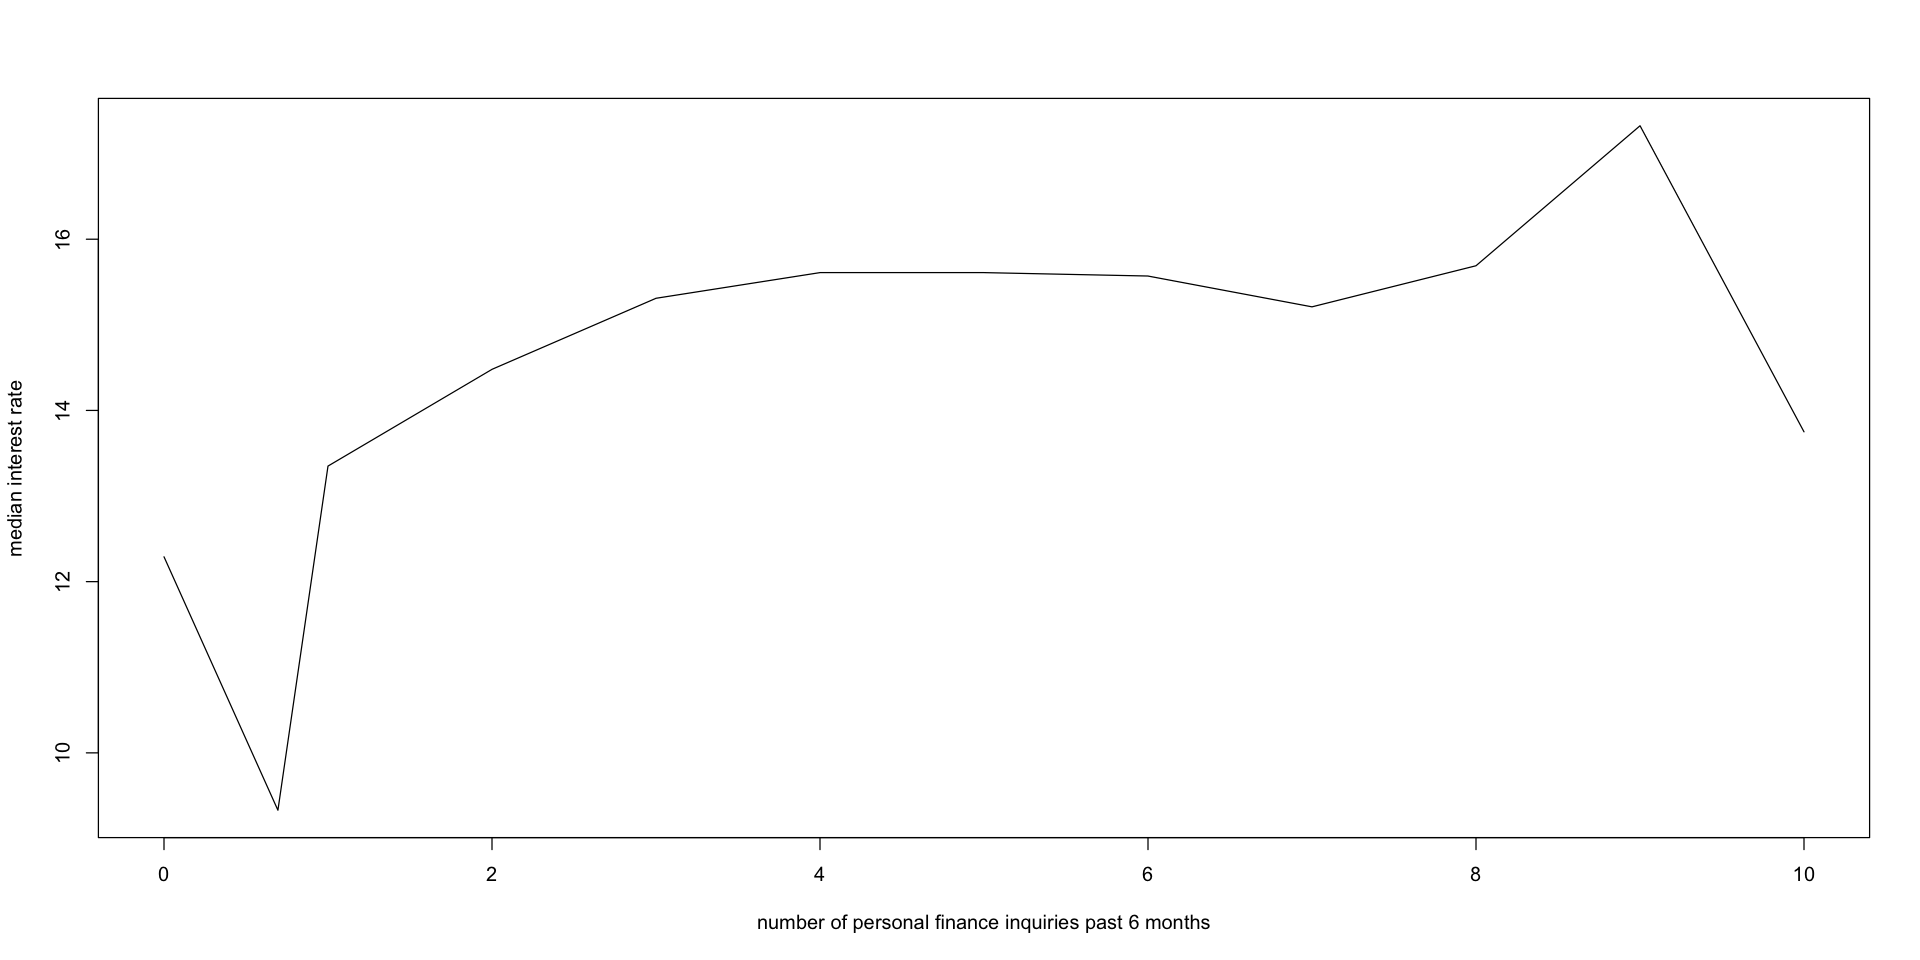

In [153]:
loan$inq_last_6mths_f <- loan$inq_last_6mths
loan$inq_last_6mths_f[which(loan$inq_last_6mths >= 10)] = 10  #replace >=10 with 10
loan$inq_last_6mths_f[which(is.na(loan$inq_last_6mths))] = mean(loan$inq_last_6mths, na.rm=T)  #replace NA with mean

inq_6months <- by(loan, loan$inq_last_6mths_f, function(x) {return(median(x$int_rate))})
plot(names(inq_6months), inq_6months, type = 'l',
    xlab="number of personal finance inquiries past 6 months",ylab="median interest rate")

In [157]:
cor(loan$inq_last_6mths, loan$int_rate, use = "pairwise.complete.obs")
cor(as.numeric(names(inq_6months)), inq_6months)

[1] 0.2277

[1] 0.6258

If we replace the NA data and trim >=10 data into =10, the coorelation coefficient between number of inquiries in last 6 months and median interest rate will increase

In [158]:
sum(is.na(loan$total_acc))/dim(loan)[1]

[1] 0.00003268

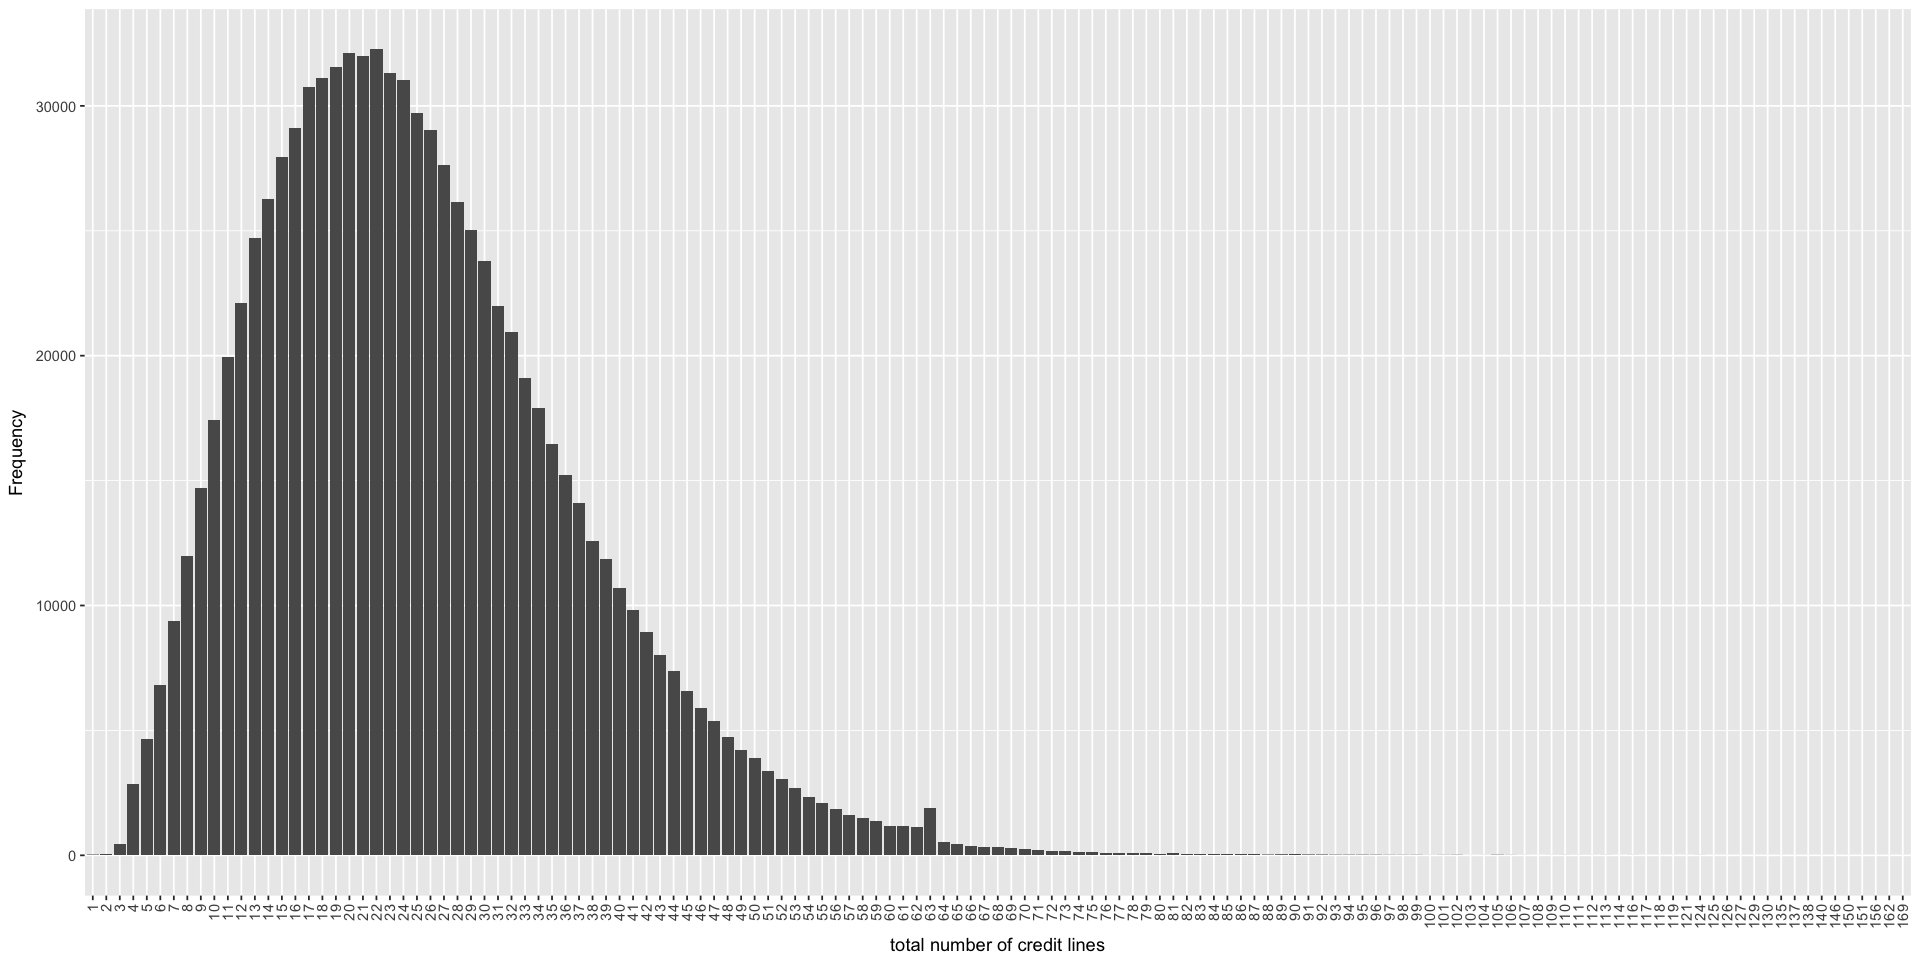

In [167]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(as.data.frame(table(loan$total_acc)), aes(x=Var1, y=Freq)) + 
geom_bar(stat="identity") + labs(x='total number of credit lines', y="Frequency")+
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=.5),
        legend.position = "none")

the number of total credit lines could be modeled as log normal distribution

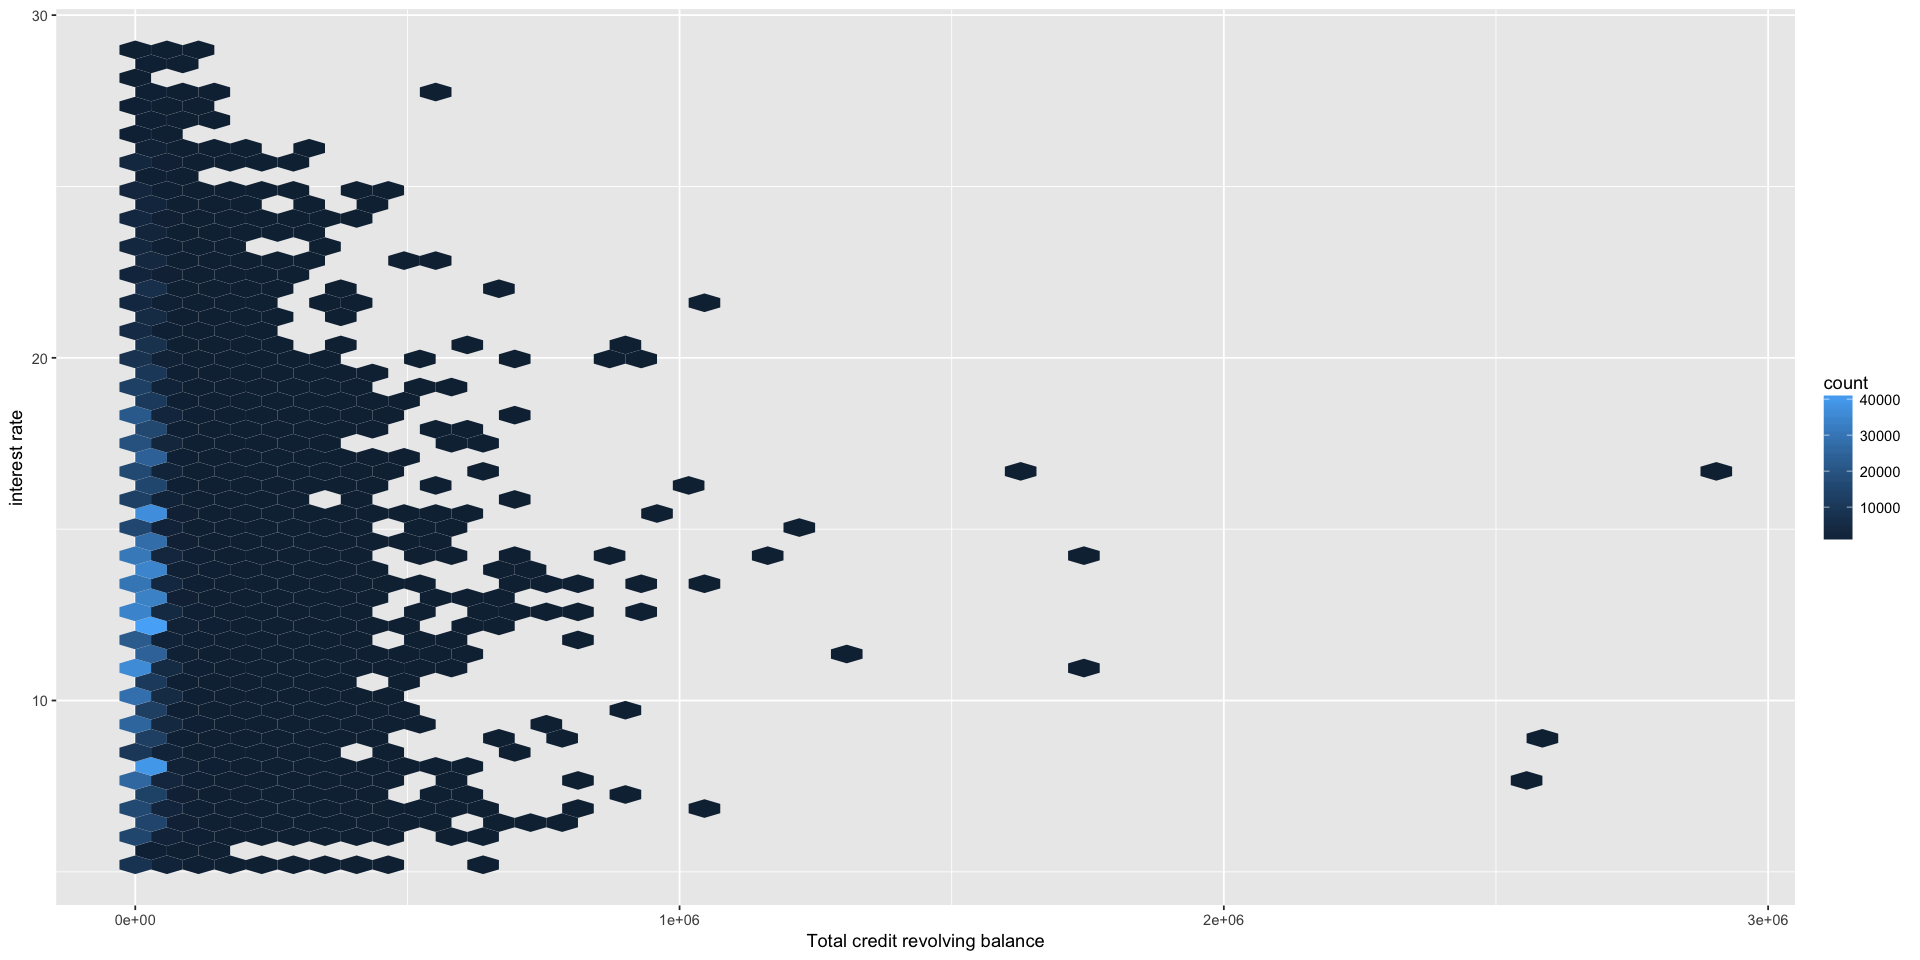

In [168]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(loan, aes(x=revol_bal, y=int_rate)) + geom_hex(bins=50)+
labs(x='Total credit revolving balance', y="interest rate")

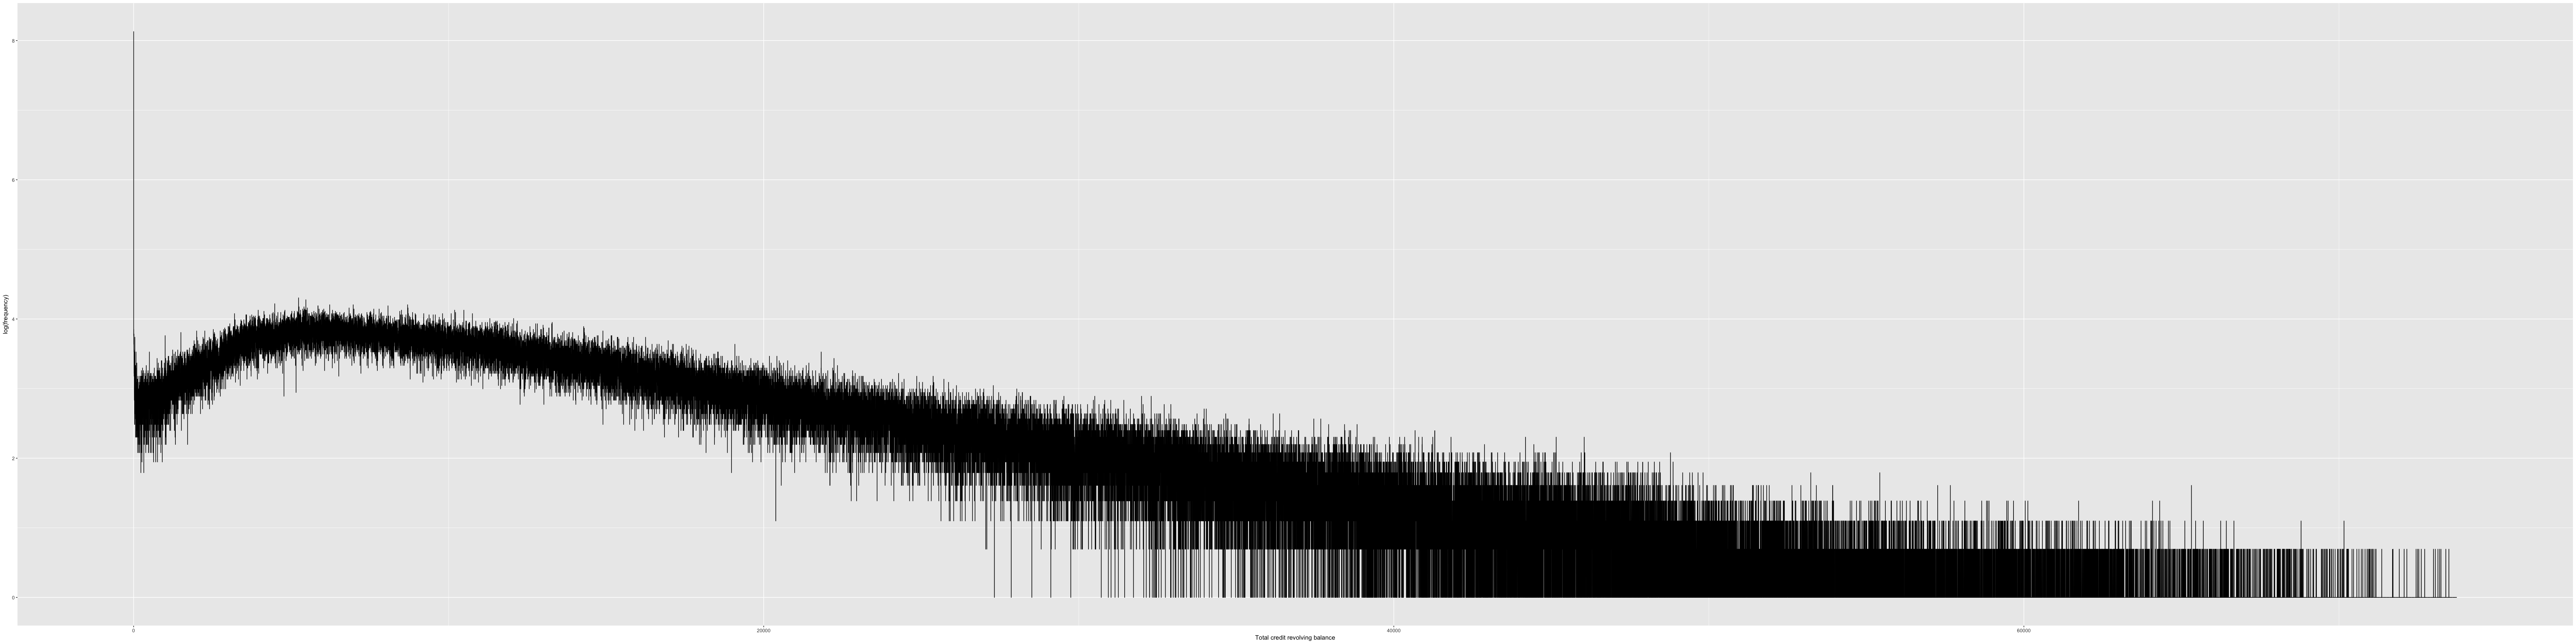

In [169]:
options(repr.plot.width=64, repr.plot.height=16)
revol_bal.data = as.data.frame(table(loan$revol_bal))
revol_bal.data = as.data.frame(sapply(revol_bal.data[, 1:2], as.numeric))
ggplot(revol_bal.data, aes(x=Var1, y=log(Freq))) + 
geom_line()+ #geom_line connects observations in order of the variable on the x axis
labs(x='Total credit revolving balance', y="log(frequency)")